# CIFAR10 classification using popular CNN classifiers

This notebook implements and benchmarks various popular CNN architectures for image classification on CIFAR10. In particular we compare networks adapted from:
- LeNet5  
- AlexNet  
- VGG
- ResNet
- GoogLeNet (Inception networks)  

Each network is adapted to take 32x32 CIFAR10 color images as input and implemented and trained from scratch. Note that we do not implement the exact same model archicture as they were presented in their original papers, since those models were originally proposed for ImageNet images which are much larger. Here we implemented smaller networks inspired by those models, which can be trained in reasonable time. We compare different variants, i.e. with different number of layers etc.

# 1) Load CIFAR10 data, prepare data loaders

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.nn import functional as F


import numpy as np
import matplotlib.pyplot as plt


import utils
import utils.data, utils.ML, utils.models
from utils.models import number_of_parameters

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 256

trainset = torchvision.datasets.CIFAR10(root='/Users/lucas/Documents/Data/', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='/Users/lucas/Documents/Data/', train=False, download=True, transform=transform)

# split training data into train and validation sets:
train_split, val_split = torch.utils.data.random_split(
    trainset, [40000, 10000],
    generator=torch.Generator().manual_seed(42))

# Create data loaders.
train_dataloader = torch.utils.data.DataLoader(train_split, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_split, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

dataloaders = [train_dataloader, val_dataloader, test_dataloader]

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
X, y = next(iter(test_dataloader))

print(X.shape)

torch.Size([256, 3, 32, 32])


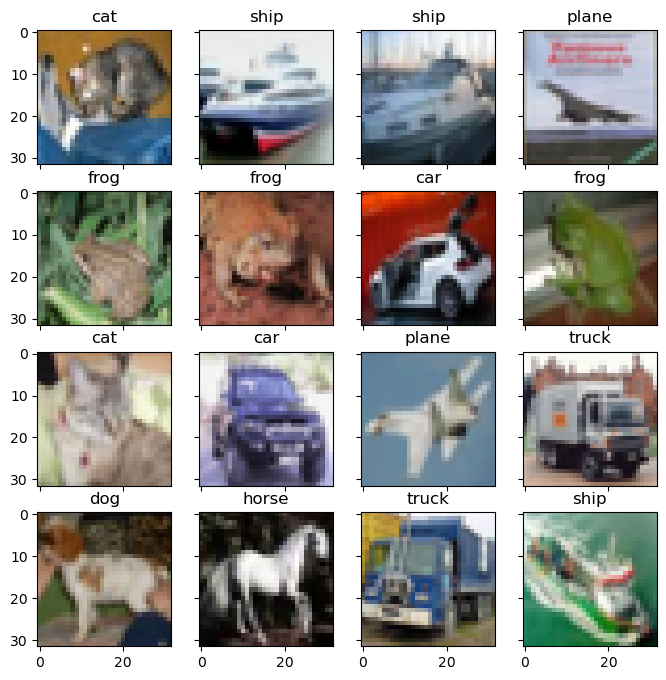

In [142]:
for i_batch, (X, y) in enumerate(test_dataloader):

    if i_batch > 0:
        break
    
    fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(8, 8))

    for i, ax in enumerate(axes.ravel()):
        x = X[i] * 0.5 + 0.5
        ax.imshow(np.transpose(x, (1,2,0)))
        ax.set_title(classes[y[i]])

# 2) Baseline: Fully-Connected Network

In [15]:
device = "mps"  # use M1 GPU
# device = "cpu"

In [8]:
loss_fn = torch.nn.CrossEntropyLoss()

In [176]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(3*32*32, 4000)
        self.dropout = nn.Dropout(0.5)
        self.linear2 = nn.Linear(4000, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.linear2(x)
        return x
    
print(f'Number of parameters: {number_of_parameters(FCN())}')

In [177]:
model = FCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10

train_loss_log, val_loss_log = utils.ML.train_model(model, train_dataloader, val_dataloader, optimizer, loss_fn, num_epochs, device, verbose=True)


 epoch:  1, training loss: 1.913, validation loss 1.706, validation accuracy 0.427
 epoch:  2, training loss: 1.766, validation loss 1.729, validation accuracy 0.445
 epoch:  3, training loss: 1.771, validation loss 1.815, validation accuracy 0.441
 epoch:  4, training loss: 1.734, validation loss 1.875, validation accuracy 0.439
 epoch:  5, training loss: 1.724, validation loss 1.771, validation accuracy 0.474
 epoch:  6, training loss: 1.701, validation loss 1.791, validation accuracy 0.448
 epoch:  7, training loss: 1.713, validation loss 1.660, validation accuracy 0.486
 epoch:  8, training loss: 1.645, validation loss 1.670, validation accuracy 0.489
 epoch:  9, training loss: 1.649, validation loss 1.724, validation accuracy 0.470
 epoch: 10, training loss: 1.653, validation loss 1.690, validation accuracy 0.496
 epoch: 11, training loss: 1.619, validation loss 1.768, validation accuracy 0.491
 epoch: 12, training loss: 1.632, validation loss 1.743, validation accuracy 0.498
 epo

In [178]:
utils.ML.print_overall_metrics(model, dataloaders, loss_fn, device=device)

train loss:      1.01401, accuracy: 0.68517
validation loss: 1.94347, accuracy: 0.51380
test loss:       1.96302, accuracy: 0.50160


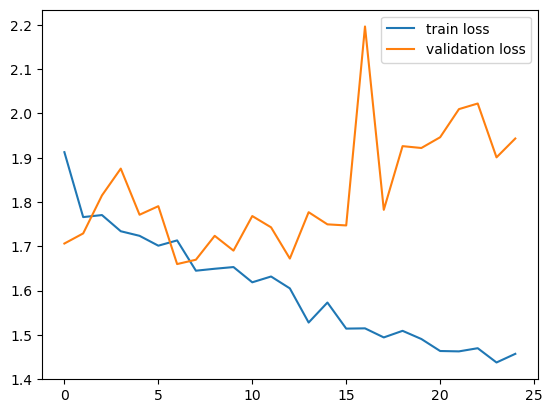

In [179]:
# Plot train and validation losses:
plt.figure()
plt.plot(train_loss_log)
plt.plot(val_loss_log)
plt.legend(["train loss", "validation loss"])

# 3) LeNet5-style network

LeNet consists of 2 stacks of convolutions with 5x5 kernels followed by pooling layers, followed by fully connected layers

In [5]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(5,5), stride=1, padding=2)   # 6x32x32
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2), stride=2, padding=0)                            # 6x16x16
        self.dropout1 = nn.Dropout(0.2)
        
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5,5), stride=1, padding=0)  # 16x12x12
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2), stride=2, padding=0)                            # 16x6x6
        self.dropout2 = nn.Dropout(0.2)
                
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(16*6*6, 120)
        self.dropout3 = nn.Dropout(0.2)
        self.dense2 = nn.Linear(120, 84)
        self.dropout4 = nn.Dropout(0.2)
        self.dense3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.dropout1(self.maxpool1(x))
        
        x = F.relu(self.conv2(x))
        x = self.dropout2(self.maxpool2(x))
                
        x = self.flatten(x)
        x = self.dropout3(F.relu(self.dense1(x)))
        x = self.dropout4(F.relu(self.dense2(x)))
        x = self.dense3(x)
        return x

In [41]:
model = LeNet5().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 25

train_loss_log, val_loss_log = utils.ML.train_model(model, train_dataloader, val_dataloader, optimizer, loss_fn, num_epochs, device, verbose=True)

 epoch:  1, training loss: 1.945, validation loss 1.660, validation accuracy 0.409
 epoch:  2, training loss: 1.635, validation loss 1.502, validation accuracy 0.454
 epoch:  3, training loss: 1.531, validation loss 1.419, validation accuracy 0.495
 epoch:  4, training loss: 1.469, validation loss 1.365, validation accuracy 0.510
 epoch:  5, training loss: 1.417, validation loss 1.312, validation accuracy 0.531
 epoch:  6, training loss: 1.364, validation loss 1.268, validation accuracy 0.545
 epoch:  7, training loss: 1.337, validation loss 1.230, validation accuracy 0.562
 epoch:  8, training loss: 1.298, validation loss 1.194, validation accuracy 0.579
 epoch:  9, training loss: 1.268, validation loss 1.163, validation accuracy 0.593
 epoch: 10, training loss: 1.245, validation loss 1.150, validation accuracy 0.599
 epoch: 11, training loss: 1.219, validation loss 1.115, validation accuracy 0.606
 epoch: 12, training loss: 1.197, validation loss 1.113, validation accuracy 0.608
 epo

In [43]:
utils.ML.print_overall_metrics(model, dataloaders, loss_fn, device=device)

train loss:      0.81911, accuracy: 0.71780
validation loss: 0.95916, accuracy: 0.65970
test loss:       0.97009, accuracy: 0.65980


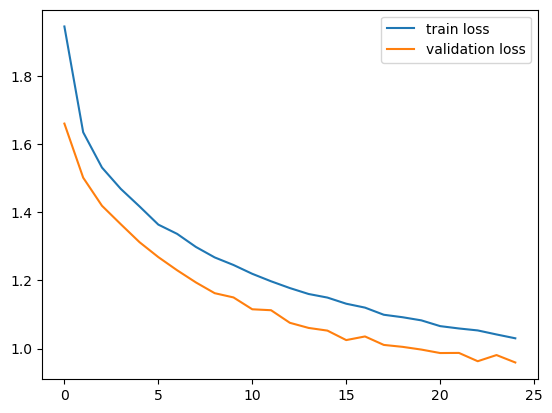

In [44]:
# Plot train and validation losses:
plt.figure()
plt.plot(train_loss_log)
plt.plot(val_loss_log)
plt.legend(["train loss", "validation loss"])

# 3) AlexNet-style network

AlexNet is inspired from LeNet but contains 5 convolutional layers (instead of 3):

In [23]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(7,7), stride=1, padding=3)   # 6x32x32
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2), stride=2, padding=0)                            # 6x16x16
        self.dropout1 = nn.Dropout(0.2)
        
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5,5), stride=1, padding=2)  # 16x16x16
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2), stride=2, padding=0)                            # 16x8x8
        self.dropout2 = nn.Dropout(0.2)
        
        self.conv3a = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=1, padding=1)  # 32x8x8
        self.conv3b = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), stride=1, padding=1)  # 32x8x8
        self.conv3c = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), stride=1, padding=1)  # 32x8x8

        self.maxpool3 = nn.MaxPool2d((2, 2), stride=2, padding=0)                                         # 32x4x4                                              # 32x4x4
        
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(32*4*4, 120)
        self.dropout3 = nn.Dropout(0.2)
        self.dense2 = nn.Linear(120, 84)
        self.dropout4 = nn.Dropout(0.2)
        self.dense3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.dropout1(self.maxpool1(x))
        
        x = F.relu(self.conv2(x))
        x = self.dropout2(self.maxpool2(x))
        
        x = F.relu(self.conv3a(x))
        x = F.relu(self.conv3b(x))
        x = F.relu(self.conv3c(x))
        x = self.maxpool3(x)
                        
        x = self.flatten(x)
        x = self.dropout3(F.relu(self.dense1(x)))
        x = self.dropout4(F.relu(self.dense2(x)))
        x = self.dense3(x)
        return x

In [24]:
model = AlexNet().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 25

train_loss_log, val_loss_log = utils.ML.train_model(model, train_dataloader, val_dataloader, optimizer, loss_fn, num_epochs, device, verbose=True)

 epoch:  1, training loss: 2.004, validation loss 1.808, validation accuracy 0.319
 epoch:  2, training loss: 1.707, validation loss 1.570, validation accuracy 0.421
 epoch:  3, training loss: 1.594, validation loss 1.514, validation accuracy 0.450
 epoch:  4, training loss: 1.513, validation loss 1.430, validation accuracy 0.477
 epoch:  5, training loss: 1.464, validation loss 1.410, validation accuracy 0.488
 epoch:  6, training loss: 1.414, validation loss 1.318, validation accuracy 0.524
 epoch:  7, training loss: 1.364, validation loss 1.327, validation accuracy 0.524
 epoch:  8, training loss: 1.330, validation loss 1.269, validation accuracy 0.542
 epoch:  9, training loss: 1.304, validation loss 1.230, validation accuracy 0.549
 epoch: 10, training loss: 1.276, validation loss 1.228, validation accuracy 0.553
 epoch: 11, training loss: 1.245, validation loss 1.203, validation accuracy 0.565
 epoch: 12, training loss: 1.216, validation loss 1.136, validation accuracy 0.590
 epo

In [25]:
utils.ML.print_overall_metrics(model, dataloaders, loss_fn, device=device)

train loss:      0.87382, accuracy: 0.69015
validation loss: 0.99411, accuracy: 0.65400
test loss:       1.00758, accuracy: 0.65040


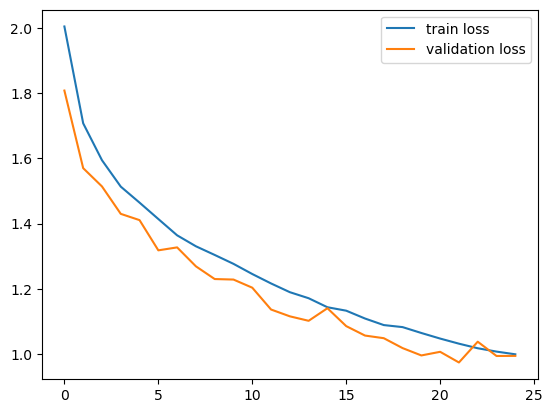

In [26]:
# Plot train and validation losses:
plt.figure()
plt.plot(train_loss_log)
plt.plot(val_loss_log)
plt.legend(["train loss", "validation loss"])

# 4) VGG-style network

The basic idea behind VGG is that a 5x5 convolution can be achieved by doing 2 sequential 3x3 convolutions, so large 5x5 or 7x7 convolutions can be replaced by sequential 3x3 convolutions. The advantage is that sequential 3x3 convolutions are less expensive than 5x5 or 7x7 convolutions. VGG-style networks thus employ fixed-size kernels of size 3x3. 

In [49]:
class VGG1(nn.Module):
    """ small VGG network with 1 convolutional block """
    def __init__(self):
        super(VGG1, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, (3, 3), stride=1, padding=1)           # 16x32x32
        self.conv2 = nn.Conv2d(16, 16, (3, 3), stride=1, padding=1)          # 16x32x32
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2), stride=2, padding=0) # 16x16x16
        self.dropout1 = nn.Dropout(0.5)
        
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(16*16*16, 512)
        self.dropout2 = nn.Dropout(0.5)
        self.dense2 = nn.Linear(512, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool1(x)
        x = self.dropout1(x)
        x = self.flatten(x)
        x = F.relu(self.dense1(x))
        x = self.dropout2(x)
        x = self.dense2(x)
        return x
    
print(f'Number of parameters: {number_of_parameters(VGG1())}')

Number of parameters: 2105562


In [40]:
model = VGG1().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 25

train_loss_log, val_loss_log = utils.ML.train_model(model, train_dataloader, val_dataloader, optimizer, loss_fn, num_epochs, device, verbose=True)

 epoch:  1, training loss: 1.568, validation loss 1.306, validation accuracy 0.530
 epoch:  2, training loss: 1.298, validation loss 1.149, validation accuracy 0.592
 epoch:  3, training loss: 1.172, validation loss 1.067, validation accuracy 0.619
 epoch:  4, training loss: 1.082, validation loss 0.992, validation accuracy 0.654
 epoch:  5, training loss: 1.018, validation loss 0.968, validation accuracy 0.663
 epoch:  6, training loss: 0.972, validation loss 0.944, validation accuracy 0.671
 epoch:  7, training loss: 0.922, validation loss 0.909, validation accuracy 0.684
 epoch:  8, training loss: 0.882, validation loss 0.898, validation accuracy 0.685
 epoch:  9, training loss: 0.852, validation loss 0.895, validation accuracy 0.689
 epoch: 10, training loss: 0.827, validation loss 0.885, validation accuracy 0.691
 epoch: 11, training loss: 0.797, validation loss 0.875, validation accuracy 0.696
 epoch: 12, training loss: 0.771, validation loss 0.878, validation accuracy 0.691
 epo

In [41]:
utils.ML.print_overall_metrics(model, dataloaders, loss_fn, device=device)

train loss:      0.24296, accuracy: 0.96032
validation loss: 0.82969, accuracy: 0.71630
test loss:       0.84968, accuracy: 0.71410


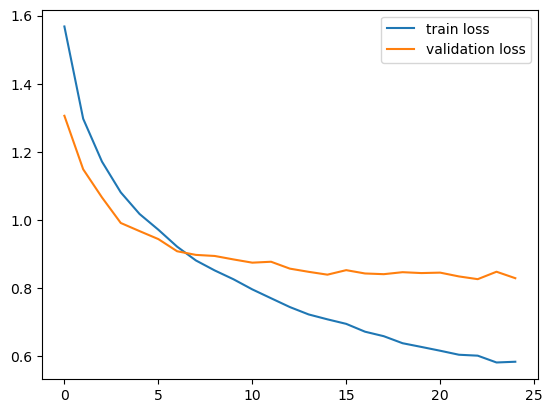

In [42]:
# Plot train and validation losses:
plt.figure()
plt.plot(train_loss_log)
plt.plot(val_loss_log)
plt.legend(["train loss", "validation loss"])

## VGG2

In [27]:
class VGG2(nn.Module):
    """ VGG network with 2 convolutional blocks """
    def __init__(self):
        super(VGG2, self).__init__()
        # Block 1:
        self.conv1 = nn.Conv2d(3, 16, (3, 3), stride=1, padding=1)           # 16x32x32
        self.conv2 = nn.Conv2d(16, 16, (3, 3), stride=1, padding=1)          # 16x32x32
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2), stride=2, padding=0) # 16x16x16
        self.dropout1 = nn.Dropout(0.5)
    
        # Block 2:
        self.conv3 = nn.Conv2d(16, 32, (3, 3), stride=1, padding=1)          # 32x16x16
        self.conv4 = nn.Conv2d(32, 32, (3, 3), stride=1, padding=1)          # 32x16x16
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2), stride=2, padding=0) # 32x8x8
        self.dropout2 = nn.Dropout(0.5)
        
        # Classifier:
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(32*8*8, 512)
        self.dropout3 = nn.Dropout(0.5)
        self.dense2 = nn.Linear(512, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool1(x)
        x = self.dropout1(x)
        
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.maxpool2(x)
        x = self.dropout2(x)
        
        x = self.flatten(x)
        x = F.relu(self.dense1(x))
        x = self.dropout2(x)
        x = self.dense2(x)
        return x
    
print(f'Number of parameters: {number_of_parameters(VGG2())}')

Number of parameters: 1070874


In [28]:
model = VGG2().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 25

train_loss_log, val_loss_log = utils.ML.train_model(model, train_dataloader, val_dataloader, optimizer, loss_fn, num_epochs, device, verbose=True)

 epoch:  1, training loss: 1.860, validation loss 1.545, validation accuracy 0.439
 epoch:  2, training loss: 1.525, validation loss 1.372, validation accuracy 0.506
 epoch:  3, training loss: 1.412, validation loss 1.302, validation accuracy 0.536
 epoch:  4, training loss: 1.340, validation loss 1.196, validation accuracy 0.580
 epoch:  5, training loss: 1.286, validation loss 1.140, validation accuracy 0.595
 epoch:  6, training loss: 1.233, validation loss 1.114, validation accuracy 0.604
 epoch:  7, training loss: 1.196, validation loss 1.079, validation accuracy 0.613
 epoch:  8, training loss: 1.163, validation loss 1.026, validation accuracy 0.639
 epoch:  9, training loss: 1.130, validation loss 1.000, validation accuracy 0.642
 epoch: 10, training loss: 1.106, validation loss 0.969, validation accuracy 0.659
 epoch: 11, training loss: 1.078, validation loss 0.971, validation accuracy 0.658
 epoch: 12, training loss: 1.073, validation loss 0.963, validation accuracy 0.658
 epo

In [29]:
utils.ML.print_overall_metrics(model, dataloaders, loss_fn, device=device)

train loss:      0.66081, accuracy: 0.77728
validation loss: 0.83262, accuracy: 0.70860
test loss:       0.84299, accuracy: 0.70970


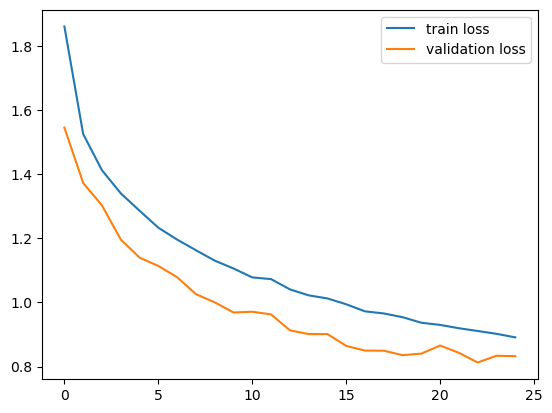

In [30]:
# Plot train and validation losses:
plt.figure()
plt.plot(train_loss_log)
plt.plot(val_loss_log)
plt.legend(["train loss", "validation loss"])

## VGG3

In [70]:
class VGG3(nn.Module):
    """ VGG with 3 convolutional blocks """
    def __init__(self):
        super(VGG3, self).__init__()
        # Block 1:
        self.conv11 = nn.Conv2d(3, 16, (3, 3), stride=1, padding=1)           # 16x32x32
        self.conv12 = nn.Conv2d(16, 16, (3, 3), stride=1, padding=1)          # 16x32x32
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2), stride=2, padding=0)  # 16x16x16
        self.dropout1 = nn.Dropout(0.5)
    
        # Block 2:
        self.conv21 = nn.Conv2d(16, 32, (3, 3), stride=1, padding=1)          # 32x16x16
        self.conv22 = nn.Conv2d(32, 32, (3, 3), stride=1, padding=1)          # 32x16x16
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2), stride=2, padding=0)  # 32x8x8
        self.dropout2 = nn.Dropout(0.5)
        
        # Block 3:
        self.conv31 = nn.Conv2d(32, 64, (3, 3), stride=1, padding=1)          # 64x8x8
        self.conv32 = nn.Conv2d(64, 64, (3, 3), stride=1, padding=1)          # 64x8x8
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2,2), stride=2, padding=0)  # 64x4x4
        self.dropout3 = nn.Dropout(0.5)
        
        # Classifier:
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(64*4*4, 512)
        self.dropoutd = nn.Dropout(0.5)
        self.dense2 = nn.Linear(512, 10)
        
    def forward(self, x):
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = self.maxpool1(x)
        x = self.dropout1(x)
        
        x = F.relu(self.conv21(x))
        x = F.relu(self.conv22(x))
        x = self.maxpool2(x)
        x = self.dropout2(x)
        
        x = F.relu(self.conv31(x))
        x = F.relu(self.conv32(x))
        x = self.maxpool3(x)
        x = self.dropout3(x)
        
        x = self.flatten(x)
        x = F.relu(self.dense1(x))
        x = self.dropoutd(x)
        x = self.dense2(x)
        return x
    
print(f'Number of parameters: {number_of_parameters(VGG3())}')

Number of parameters: 602010


In [71]:
model = VGG3().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 25

train_loss_log, val_loss_log = utils.ML.train_model(model, train_dataloader, val_dataloader, optimizer, loss_fn, num_epochs, device, verbose=True)

 epoch:  1, training loss: 1.837, validation loss 1.466, validation accuracy 0.451
 epoch:  2, training loss: 1.490, validation loss 1.276, validation accuracy 0.527
 epoch:  3, training loss: 1.368, validation loss 1.212, validation accuracy 0.558
 epoch:  4, training loss: 1.287, validation loss 1.138, validation accuracy 0.583
 epoch:  5, training loss: 1.227, validation loss 1.122, validation accuracy 0.597
 epoch:  6, training loss: 1.178, validation loss 1.127, validation accuracy 0.592
 epoch:  7, training loss: 1.151, validation loss 1.027, validation accuracy 0.624
 epoch:  8, training loss: 1.109, validation loss 0.975, validation accuracy 0.647
 epoch:  9, training loss: 1.090, validation loss 1.017, validation accuracy 0.636
 epoch: 10, training loss: 1.068, validation loss 1.024, validation accuracy 0.630
 epoch: 11, training loss: 1.054, validation loss 1.016, validation accuracy 0.641
 epoch: 12, training loss: 1.025, validation loss 0.917, validation accuracy 0.673
 epo

In [72]:
utils.ML.print_overall_metrics(model, dataloaders, loss_fn, device=device)

train loss:      0.74661, accuracy: 0.74003
validation loss: 0.82289, accuracy: 0.70920
test loss:       0.83826, accuracy: 0.70310


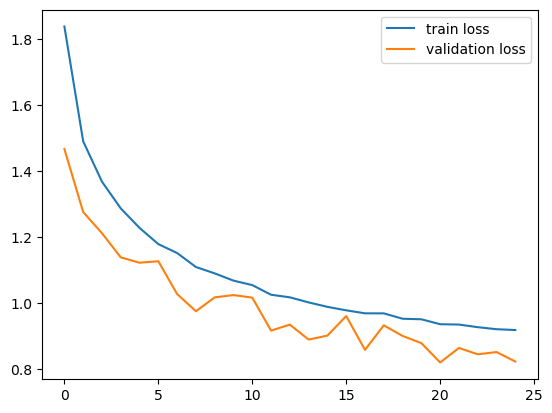

In [73]:
# Plot train and validation losses:
plt.figure()
plt.plot(train_loss_log)
plt.plot(val_loss_log)
plt.legend(["train loss", "validation loss"])

# 5) ResNet-type architecture

The idea is to implement "skip-connections", in order to overcome the vanishing gradient problem when building deeper network.

Paper: [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)

We reproduce the implementation for CIFAR10 described by the authors (here with n = 3):

"_The first layer is 3×3 convolutions. Then we use a stack of 6n layers with 3×3 convolutions on the feature maps of sizes {32, 16, 8} respectively, with 2n layers for each feature map size. The numbers of filters are {16, 32, 64} respectively. The subsampling is performed by convolutions with a stride of 2. The network ends with a global average pooling, a 10-way fully-connected layer, and softmax. There are totally 6n+2 stacked weighted layers._"

In order to test the performace of skip-connections, we first implement a _plain_ but relatively deep network without any skip-connections, and compare that same network with additional skip connections.

In [120]:
class ResNet_plain(nn.Module):
    def __init__(self):
        super(ResNet_plain, self).__init__()
                                                                              # input: 3x32x32
        self.conv0 = nn.Conv2d(3, 16, (3, 3), stride=1, padding=1)
        
        # Block 1:
        self.conv11 = nn.Conv2d(16, 16, (3, 3), stride=1, padding=1)          # 16x32x32
        self.conv12 = nn.Conv2d(16, 16, (3, 3), stride=1, padding=1)          # 16x32x32
        self.conv13 = nn.Conv2d(16, 16, (3, 3), stride=1, padding=1)          # 16x32x32
        self.conv14 = nn.Conv2d(16, 16, (3, 3), stride=1, padding=1)          # 16x32x32
        self.conv15 = nn.Conv2d(16, 16, (3, 3), stride=1, padding=1)          # 16x32x32
        self.conv16 = nn.Conv2d(16, 16, (3, 3), stride=1, padding=1)          # 16x32x32
        
        # Block 2:
        self.conv21 = nn.Conv2d(16, 32, (3, 3), stride=2, padding=1)          # 32x16x16
        self.conv22 = nn.Conv2d(32, 32, (3, 3), stride=1, padding=1)          # 32x16x16
        self.conv23 = nn.Conv2d(32, 32, (3, 3), stride=1, padding=1)          # 32x16x16
        self.conv24 = nn.Conv2d(32, 32, (3, 3), stride=1, padding=1)          # 32x16x16
        self.conv25 = nn.Conv2d(32, 32, (3, 3), stride=1, padding=1)          # 32x16x16
        self.conv26 = nn.Conv2d(32, 32, (3, 3), stride=1, padding=1)          # 32x16x16
        
        # Block 3:
        self.conv31 = nn.Conv2d(32, 64, (3, 3), stride=2, padding=1)          # 64x8x8
        self.conv32 = nn.Conv2d(64, 64, (3, 3), stride=1, padding=1)          # 64x8x8
        self.conv33 = nn.Conv2d(64, 64, (3, 3), stride=1, padding=1)          # 64x8x8
        self.conv34 = nn.Conv2d(64, 64, (3, 3), stride=1, padding=1)          # 64x8x8
        self.conv35 = nn.Conv2d(64, 64, (3, 3), stride=1, padding=1)          # 64x8x8
        self.conv36 = nn.Conv2d(64, 64, (3, 3), stride=1, padding=1)          # 64x8x8
        
        self.avgpool = nn.AvgPool2d((8, 8))                                   # 64x1x1
        
        # Classifier:
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(64, 10)
        
    def forward(self, x):
        
        x0 = self.conv0(x)
        
        x11 = F.relu(self.conv11(x0))
        x12 = F.relu(self.conv12(x11))
        x13 = F.relu(self.conv13(x12))
        x14 = F.relu(self.conv14(x13))
        x15 = F.relu(self.conv15(x14))
        x16 = F.relu(self.conv16(x15))
        
        x21 = F.relu(self.conv21(x16))
        x22 = F.relu(self.conv22(x21))
        x23 = F.relu(self.conv23(x22))
        x24 = F.relu(self.conv24(x23))
        x25 = F.relu(self.conv25(x24))
        x26 = F.relu(self.conv26(x25))
        
        x31 = F.relu(self.conv31(x26))
        x32 = F.relu(self.conv32(x31))
        x33 = F.relu(self.conv33(x32))
        x34 = F.relu(self.conv34(x33))
        x35 = F.relu(self.conv35(x34))
        x36 = F.relu(self.conv36(x35))
        
        x = self.avgpool(x36)
        x = self.flatten(x)
        x = self.dense(x)
        return x
    
print(f'Number of parameters: {number_of_parameters(ResNet_plain())}')

Number of parameters: 269034


In [121]:
model = ResNet_plain().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5*1e-4)

num_epochs = 25

train_loss_log, val_loss_log = utils.ML.train_model(model, train_dataloader, val_dataloader, optimizer, loss_fn, num_epochs, device, verbose=True)

 epoch:  1, training loss: 2.161, validation loss 2.007, validation accuracy 0.245
 epoch:  2, training loss: 1.874, validation loss 1.828, validation accuracy 0.299
 epoch:  3, training loss: 1.772, validation loss 1.774, validation accuracy 0.328
 epoch:  4, training loss: 1.691, validation loss 1.627, validation accuracy 0.388
 epoch:  5, training loss: 1.624, validation loss 1.586, validation accuracy 0.405
 epoch:  6, training loss: 1.550, validation loss 1.517, validation accuracy 0.435
 epoch:  7, training loss: 1.505, validation loss 1.462, validation accuracy 0.459
 epoch:  8, training loss: 1.457, validation loss 1.458, validation accuracy 0.467
 epoch:  9, training loss: 1.406, validation loss 1.446, validation accuracy 0.468
 epoch: 10, training loss: 1.365, validation loss 1.384, validation accuracy 0.492
 epoch: 11, training loss: 1.332, validation loss 1.349, validation accuracy 0.511
 epoch: 12, training loss: 1.292, validation loss 1.304, validation accuracy 0.521
 epo

In [122]:
utils.ML.print_overall_metrics(model, dataloaders, loss_fn, device=device)

train loss:      0.79273, accuracy: 0.72165
validation loss: 1.16170, accuracy: 0.59440
test loss:       1.14531, accuracy: 0.60130


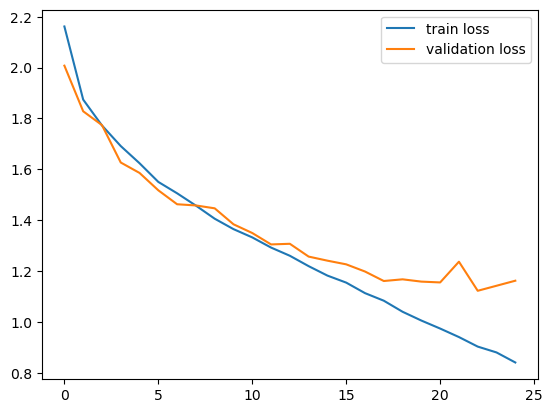

In [123]:
# Plot train and validation losses:
plt.figure()
plt.plot(train_loss_log)
plt.plot(val_loss_log)
plt.legend(["train loss", "validation loss"])

In [136]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
                                                                              # input: 3x32x32
        self.conv0 = nn.Conv2d(3, 16, (3, 3), stride=1, padding=1)
                
        # Block 1:
        self.conv11 = nn.Conv2d(16, 16, (3, 3), stride=1, padding=1)          # 16x32x32
        self.conv12 = nn.Conv2d(16, 16, (3, 3), stride=1, padding=1)          # 16x32x32
        self.conv13 = nn.Conv2d(16, 16, (3, 3), stride=1, padding=1)          # 16x32x32
        self.conv14 = nn.Conv2d(16, 16, (3, 3), stride=1, padding=1)          # 16x32x32
        self.conv15 = nn.Conv2d(16, 16, (3, 3), stride=1, padding=1)          # 16x32x32
        self.conv16 = nn.Conv2d(16, 16, (3, 3), stride=1, padding=1)          # 16x32x32
        
        self.res1 = nn.Conv2d(16, 32, (1, 1), stride=2, padding=0, bias=False)
        
        # Block 2:
        self.conv21 = nn.Conv2d(16, 32, (3, 3), stride=2, padding=1)          # 32x16x16
        self.conv22 = nn.Conv2d(32, 32, (3, 3), stride=1, padding=1)          # 32x16x16
        self.conv23 = nn.Conv2d(32, 32, (3, 3), stride=1, padding=1)          # 32x16x16
        self.conv24 = nn.Conv2d(32, 32, (3, 3), stride=1, padding=1)          # 32x16x16
        self.conv25 = nn.Conv2d(32, 32, (3, 3), stride=1, padding=1)          # 32x16x16
        self.conv26 = nn.Conv2d(32, 32, (3, 3), stride=1, padding=1)          # 32x16x16
        
        self.res2 = nn.Conv2d(32, 64, (1, 1), stride=2, padding=0, bias=False)

        # Block 3:
        self.conv31 = nn.Conv2d(32, 64, (3, 3), stride=2, padding=1)          # 64x8x8
        self.conv32 = nn.Conv2d(64, 64, (3, 3), stride=1, padding=1)          # 64x8x8
        self.conv33 = nn.Conv2d(64, 64, (3, 3), stride=1, padding=1)          # 64x8x8
        self.conv34 = nn.Conv2d(64, 64, (3, 3), stride=1, padding=1)          # 64x8x8
        self.conv35 = nn.Conv2d(64, 64, (3, 3), stride=1, padding=1)          # 64x8x8
        self.conv36 = nn.Conv2d(64, 64, (3, 3), stride=1, padding=1)          # 64x8x8
        
        self.maxpool = nn.MaxPool2d((8, 8))                                   # 64x1x1
        
        # Classifier:
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(64, 10)
        
    def forward(self, x):
        
        x0 = self.conv0(x)
        
        x11 = F.relu(self.conv11(x0))
        x12 = F.relu(self.conv12(x11)+x0)   # residual connection
        x13 = F.relu(self.conv13(x12))
        x14 = F.relu(self.conv14(x13)+x12)  # residual connection
        x15 = F.relu(self.conv15(x14))
        x16 = F.relu(self.conv16(x15)+x14)  # residual connection
        
        x21 = F.relu(self.conv21(x16))
        x22 = F.relu(self.conv22(x21)+self.res1(x16))  # res. connection with downscaling and increased depth
        x23 = F.relu(self.conv23(x22))
        x24 = F.relu(self.conv24(x23)+x22)  # residual connection
        x25 = F.relu(self.conv25(x24))
        x26 = F.relu(self.conv26(x25)+x24)  # residual connection
        
        x31 = F.relu(self.conv31(x26))
        x32 = F.relu(self.conv32(x31)+self.res2(x26))  # res. connection with downscaling and increased depth
        x33 = F.relu(self.conv33(x32))
        x34 = F.relu(self.conv34(x33)+x32)  # residual connection
        x35 = F.relu(self.conv35(x34))
        x36 = F.relu(self.conv36(x35)+x34)  # residual connection
        
        x = self.maxpool(x36)
        x = self.flatten(x)
        x = self.dense(x)
        return x
    
print(f'Number of parameters: {number_of_parameters(ResNet())}')

Number of parameters: 271690


In [137]:
model = ResNet().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5*1e-4)

num_epochs = 25

train_loss_log, val_loss_log = utils.ML.train_model(model, train_dataloader, val_dataloader, optimizer, loss_fn, num_epochs, device, verbose=True)

 epoch:  1, training loss: 1.871, validation loss 1.621, validation accuracy 0.414
 epoch:  2, training loss: 1.543, validation loss 1.450, validation accuracy 0.473
 epoch:  3, training loss: 1.390, validation loss 1.359, validation accuracy 0.506
 epoch:  4, training loss: 1.287, validation loss 1.323, validation accuracy 0.529
 epoch:  5, training loss: 1.189, validation loss 1.226, validation accuracy 0.569
 epoch:  6, training loss: 1.113, validation loss 1.167, validation accuracy 0.596
 epoch:  7, training loss: 1.046, validation loss 1.121, validation accuracy 0.607
 epoch:  8, training loss: 0.986, validation loss 1.053, validation accuracy 0.629
 epoch:  9, training loss: 0.932, validation loss 0.994, validation accuracy 0.652
 epoch: 10, training loss: 0.874, validation loss 0.962, validation accuracy 0.666
 epoch: 11, training loss: 0.823, validation loss 1.000, validation accuracy 0.654
 epoch: 12, training loss: 0.786, validation loss 0.923, validation accuracy 0.677
 epo

In [138]:
utils.ML.print_overall_metrics(model, dataloaders, loss_fn, device=device)

train loss:      0.24454, accuracy: 0.91380
validation loss: 1.31756, accuracy: 0.66960
test loss:       1.36691, accuracy: 0.65540


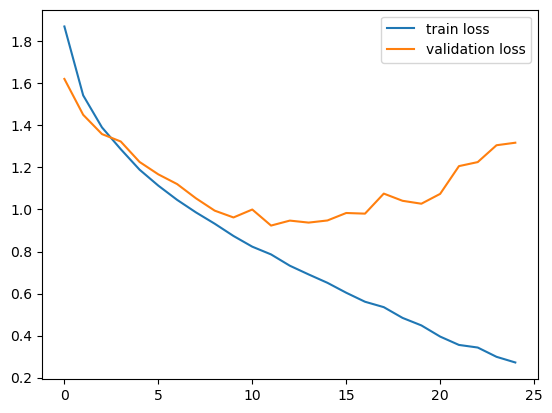

In [139]:
# Plot train and validation losses:
plt.figure()
plt.plot(train_loss_log)
plt.plot(val_loss_log)
plt.legend(["train loss", "validation loss"])

# 6) Inception-style architecture (GoogLeNet)

The idea is to use kernels of different size (1x1, 3x3, 5x5) in parallel, and then to concatenate the results. The motivation being that kernel of different sizes will capture features of different sizes.

Paper: [Going Deeper With Convolutions](https://arxiv.org/pdf/1409.4842v1.pdf)

Since concatenating layers can result in potentially large networks, to reduce complexity the authors also proposed dimension-reduction layers (implemented as 1x1 convolutions) in order to keep the number of filters manageable. We implemement one Inception network with 2 Inception blocks and no dimension reduction, and one network with 3 blocks with dimension reduction in the last 2 blocks.

In [18]:
class Inception(nn.Module):
    
    def __init__(self):
        super(Inception, self).__init__()
        
        # stem:
        self.conv0 = nn.Conv2d(3, 16, (3, 3), padding=1, stride=1)           # 16x32x32
        self.maxpool0 = nn.MaxPool2d((3, 3), padding=1, stride=2)            # 16x16x16
        
        # Inception block 1:
        self.conv1a = nn.Conv2d(16, 32, (1, 1), padding=0, stride=1)         # 32x16x16
        self.conv1b = nn.Conv2d(16, 32, (3, 3), padding=1, stride=1)         # 32x16x16
        self.conv1c = nn.Conv2d(16, 32, (5, 5), padding=2, stride=1)         # 32x16x16
        self.maxpool1d = nn.MaxPool2d((3, 3), padding=1, stride=1)           # 16x16x16
                                                                        # --> concat: 112x16x16
            
        self.maxpool1 = nn.MaxPool2d((3, 3), padding=1, stride=2)            # 112x8x8
        
        # Inception block 2:
        self.conv2a = nn.Conv2d(112, 64, (1, 1), padding=0, stride=1)        # 64x8x8
        self.conv2b = nn.Conv2d(112, 64, (3, 3), padding=1, stride=1)        # 64x8x8
        self.conv2c = nn.Conv2d(112, 64, (5, 5), padding=2, stride=1)        # 64x8x8
        self.maxpool2d = nn.MaxPool2d((3, 3), padding=1, stride=1)           # 112x8x8
                                                                        # --> concat: 304x8x8  
        
        self.maxpool2 = nn.MaxPool2d((3, 3), padding=1, stride=2)            # 304x4x4

        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(304*4*4, 256)
        self.dropout = nn.Dropout(0.5)
        self.dense2 = nn.Linear(256, 10)
        
    def forward(self, x):
        
        x = F.relu(self.conv0(x))
        x = self.maxpool0(x)
        
        x1a = F.relu(self.conv1a(x))
        x1b = F.relu(self.conv1b(x))
        x1c = F.relu(self.conv1c(x))
        x1d = self.maxpool1d(x)
        x = torch.cat([x1a, x1b, x1c, x1d], dim=1)
        x = self.maxpool1(x)
        
        x2a = F.relu(self.conv2a(x))
        x2b = F.relu(self.conv2b(x))
        x2c = F.relu(self.conv2c(x))
        x2d = self.maxpool2d(x)
        x = torch.cat([x2a, x2b, x2c, x2d], dim=1)
        x = self.maxpool2(x)
        
        x = self.flatten(x)
        x = F.relu(self.dense1(x))
        x = self.dropout(x)
        x = self.dense2(x)
        
        return x
            
print(f'Number of parameters: {number_of_parameters(Inception())}')

Number of parameters: 1517546


In [19]:
model = Inception().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 25

train_loss_log, val_loss_log = utils.ML.train_model(model, train_dataloader, val_dataloader, optimizer, loss_fn, num_epochs, device, verbose=True)

 epoch:  1, training loss: 1.770, validation loss 1.448, validation accuracy 0.468
 epoch:  2, training loss: 1.404, validation loss 1.221, validation accuracy 0.564
 epoch:  3, training loss: 1.242, validation loss 1.097, validation accuracy 0.609
 epoch:  4, training loss: 1.140, validation loss 1.049, validation accuracy 0.624
 epoch:  5, training loss: 1.044, validation loss 0.955, validation accuracy 0.657
 epoch:  6, training loss: 0.975, validation loss 0.881, validation accuracy 0.686
 epoch:  7, training loss: 0.913, validation loss 0.845, validation accuracy 0.698
 epoch:  8, training loss: 0.868, validation loss 0.828, validation accuracy 0.706
 epoch:  9, training loss: 0.820, validation loss 0.785, validation accuracy 0.716
 epoch: 10, training loss: 0.782, validation loss 0.776, validation accuracy 0.724
 epoch: 11, training loss: 0.750, validation loss 0.740, validation accuracy 0.741
 epoch: 12, training loss: 0.722, validation loss 0.748, validation accuracy 0.732
 epo

In [20]:
utils.ML.print_overall_metrics(model, dataloaders, loss_fn, device=device)

train loss:      0.31347, accuracy: 0.89287
validation loss: 0.71252, accuracy: 0.76110
test loss:       0.72944, accuracy: 0.76260


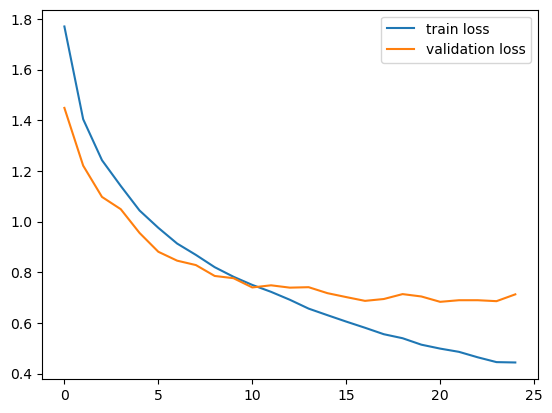

In [21]:
# Plot train and validation losses:
plt.figure()
plt.plot(train_loss_log)
plt.plot(val_loss_log)
plt.legend(["train loss", "validation loss"])

In [39]:
class Inception2(nn.Module):
    
    def __init__(self):
        super(Inception2, self).__init__()
        
        # stem:
        self.conv0 = nn.Conv2d(3, 16, (3, 3), padding=1, stride=1)           # 16x32x32
        self.maxpool0 = nn.MaxPool2d((3, 3), padding=1, stride=2)            # 16x16x16
        
        # Inception block 1:
        self.conv1a = nn.Conv2d(16, 32, (1, 1), padding=0, stride=1)         # 32x16x16
        self.conv1b = nn.Conv2d(16, 32, (3, 3), padding=1, stride=1)         # 32x16x16
        self.conv1c = nn.Conv2d(16, 16, (5, 5), padding=2, stride=1)         # 16x16x16
        self.maxpool1d = nn.MaxPool2d((3, 3), padding=1, stride=1)           # 16x16x16
                                                                        # --> concat: 96x16x16
            
        self.maxpool1 = nn.MaxPool2d((3, 3), padding=1, stride=2)            # 96x8x8
        
        
        # Inception block 2 w/ reduced dimensions:
        self.conv2a        = nn.Conv2d(96, 64, (1, 1), padding=0, stride=1)   # 64x8x8
        self.conv2b_red    = nn.Conv2d(96, 64, (1, 1), padding=0, stride=1)
        self.conv2b        = nn.Conv2d(64, 128, (3, 3), padding=1, stride=1)  # 128x8x8
        self.conv2c_red    = nn.Conv2d(96, 16, (1, 1), padding=0, stride=1)
        self.conv2c        = nn.Conv2d(16, 32, (5, 5), padding=2, stride=1)   # 32x8x8
        self.maxpool2d     = nn.MaxPool2d((3, 3), padding=1, stride=1)           
        self.maxpool2d_red = nn.Conv2d(96, 64, (1, 1), padding=0, stride=1)   # 64x8x8
                                                                        # --> concat: 288x8x8  
        
        self.maxpool2 = nn.MaxPool2d((3, 3), padding=1, stride=2)             # 288x4x4
        
        
        # Inception block 3 w/ reduced dimensions:
        self.conv3a        = nn.Conv2d(288, 128, (1, 1), padding=0, stride=1)  # 128x4x4
        self.conv3b_red    = nn.Conv2d(288, 128, (1, 1), padding=0, stride=1)
        self.conv3b        = nn.Conv2d(128, 256, (3, 3), padding=1, stride=1)  # 256x4x4
        self.conv3c_red    = nn.Conv2d(288, 32, (1, 1), padding=0, stride=1)
        self.conv3c        = nn.Conv2d(32, 32, (5, 5), padding=2, stride=1)    # 32x4x4
        self.maxpool3d     = nn.MaxPool2d((3, 3), padding=1, stride=1)           
        self.maxpool3d_red = nn.Conv2d(288, 128, (1, 1), padding=0, stride=1)  # 128x4x4
                                                                        # --> concat: 544x4x4  
        
        self.maxpool3 = nn.MaxPool2d((3, 3), padding=1, stride=2)             # 544x2x2    
        
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(544*2*2, 256)
        self.dropout = nn.Dropout(0.5)
        self.dense2 = nn.Linear(256, 10)
        
    def forward(self, x):
        
        x = F.relu(self.conv0(x))
        x = self.maxpool0(x)
        
        # Inception block 1:
        x1a = F.relu(self.conv1a(x))
        x1b = F.relu(self.conv1b(x))
        x1c = F.relu(self.conv1c(x))
        x1d = self.maxpool1d(x)
        x = torch.cat([x1a, x1b, x1c, x1d], dim=1)
        x = self.maxpool1(x)
        
        # Inception block 2 w/ reduced dimensions:
        x2a = F.relu(self.conv2a(x))
        x2b_red = F.relu(self.conv2b_red(x))
        x2b = F.relu(self.conv2b(x2b_red))
        x2c_red = F.relu(self.conv2c_red(x))
        x2c = F.relu(self.conv2c(x2c_red))
        x2d = self.maxpool2d(x)
        x2d_red = F.relu(self.maxpool2d_red(x2d))
        x = torch.cat([x2a, x2b, x2c, x2d_red], dim=1)
        x = self.maxpool2(x)
        
        # Inception block 3 w/ reduced dimensions:
        x3a = F.relu(self.conv3a(x))
        x3b_red = F.relu(self.conv3b_red(x))
        x3b = F.relu(self.conv3b(x3b_red))
        x3c_red = F.relu(self.conv3c_red(x))
        x3c = F.relu(self.conv3c(x3c_red))
        x3d = self.maxpool2d(x)
        x3d_red = F.relu(self.maxpool3d_red(x3d))
        x = torch.cat([x3a, x3b, x3c, x3d_red], dim=1)
        x = self.maxpool3(x)
        
        x = self.flatten(x)
        x = F.relu(self.dense1(x))
        x = self.dropout(x)
        x = self.dense2(x)
        
        return x
            
print(f'Number of parameters: {number_of_parameters(Inception2())}')

Number of parameters: 1119818


In [36]:
model = Inception2().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 25

train_loss_log, val_loss_log = utils.ML.train_model(model, train_dataloader, val_dataloader, optimizer, loss_fn, num_epochs, device, verbose=True)

 epoch:  1, training loss: 1.857, validation loss 1.540, validation accuracy 0.419
 epoch:  2, training loss: 1.491, validation loss 1.423, validation accuracy 0.474
 epoch:  3, training loss: 1.336, validation loss 1.238, validation accuracy 0.551
 epoch:  4, training loss: 1.213, validation loss 1.158, validation accuracy 0.577
 epoch:  5, training loss: 1.110, validation loss 1.038, validation accuracy 0.626
 epoch:  6, training loss: 1.027, validation loss 1.010, validation accuracy 0.635
 epoch:  7, training loss: 0.963, validation loss 0.935, validation accuracy 0.669
 epoch:  8, training loss: 0.872, validation loss 0.899, validation accuracy 0.682
 epoch:  9, training loss: 0.834, validation loss 0.861, validation accuracy 0.696
 epoch: 10, training loss: 0.774, validation loss 0.854, validation accuracy 0.699
 epoch: 11, training loss: 0.713, validation loss 0.819, validation accuracy 0.716
 epoch: 12, training loss: 0.670, validation loss 0.797, validation accuracy 0.723
 epo

In [37]:
utils.ML.print_overall_metrics(model, dataloaders, loss_fn, device=device)

train loss:      0.14330, accuracy: 0.94993
validation loss: 1.07981, accuracy: 0.74170
test loss:       1.07553, accuracy: 0.73770


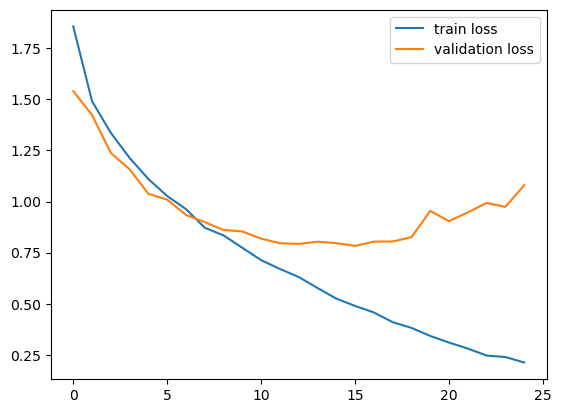

In [38]:
# Plot train and validation losses:
plt.figure()
plt.plot(train_loss_log)
plt.plot(val_loss_log)
plt.legend(["train loss", "validation loss"])